# Prepocessing and data selection 

In [1]:
from GG_mthesis import *
import metpy
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.units import units
%matplotlib inline

In [2]:
os.getcwd()

'C:\\Users\\gian_\\repos\\mthesis_gianlucca'

In [3]:
# sns.set_style('whitegrid')
# sns.set_palette('colorblind')
# sns.set(font_scale=1.2)

## Reshaping

In [53]:
#define the path
path = '.\\data\\01_raw\\JR16002\\b1836415.nc'

#open the dataset with the defined path
ds_orig = xr.open_dataset(path) 

#Squeeze eliminates dimensions of length 0 and 1. Drop REFMAX as it is not needed. Swap MAXT (count) with TIME 
#to make TIME unique dimension (MAXT is a count a not needed, you can access the same with .isel). Rename coords to
#my standard.
ds = ds_orig.squeeze().drop_dims('REFMAX').swap_dims({'MAXT':'TIME'}).rename({
    'LONGITUDE':'lon','LATITUDE':'lat','TIME':'time','DEPTH':'depth'})

#Definition of new time attributes (datetime). Retrieved from original dataset and modified.
new_time_attr = {'long_name': 'Chronological DateTime Date',
 'standard_name': 'time',
 'ancillary_variables': 'TIME_SEADATANET_QC',
 'axis': 'T',
 'valid_min': 0.0,
 'valid_max': 2500000.0,
 'sdn_parameter_urn': 'SDN:P01::CJDY1101',
 'sdn_parameter_name': 'DateTime (chronological)',
 'sdn_uom_name': 'Days',
 'sdn_uom_urn': 'SDN:P06::UTAA'}

#Pull out the index (a CFTimeIndex) and use built in to_datetimeindex method.
datetimeindex = ds.indexes['time'].to_datetimeindex()

#Replace CFTimeIndex with DateTimeIndex:
ds['time'] = datetimeindex

#Attach new attributes
ds['time'].attrs = new_time_attr

C:\Users\gian_\miniconda3\envs\mthesis\lib\site-packages\xarray\coding\times.py:174: CFWarning: this date/calendar/year zero convention is not supported by CF
  cftime.num2date(num_dates, units, calendar, only_use_cftime_datetimes=True)
C:\Users\gian_\AppData\Local\Temp/ipykernel_21704/626543454.py:26: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = ds.indexes['time'].to_datetimeindex()


## Bathmetry - data selection

In [5]:
etopo1 = xr.open_dataset(r'data/01_raw/ETOPO1_Bed_g_gmt4.grd',engine='netcdf4')

In [6]:
# import cmocean.cm as cm
# fig= plt.figure(figsize=(14,12))
# ax = plt.axes(projection=ccrs.PlateCarree())
# x = etopo1.x
# y = etopo1.y
# z = etopo1.z
# vmin = z.min()
# vmax = z.max()
# topo_f = ax.contourf(x, y, z, 
#                 cmap = cm.deep_r,
#                     # vmin = vmin,
#                     # vmax = 0,
#                 #    norm=MidpointNormalize(
#                 #        midpoint=-1000,
#                 #        vmin=vmin,lines
#                 #        vmax=0
#                 #     ),
#                 levels=20
#                 )
# #plt.colorbar(ScalarMappable(norm=topo_f.norm, cmap=topo_f.cmap), pad=0.02)

# # topo = ax.contour(x, y, z, 
# #                   colors = 'black',
# #                 #    vmin = vmin,
# #                    levels=[-5500,-4500,-3000,-1500]
# #                    )
# #ax.clabel(topo)

In [7]:
etopo1 = etopo1.sel(x=slice(-62,-52), y=slice(-64,-52))

In [8]:
import matplotlib.colors as colors
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [9]:
ds_ACC_fronts = xr.load_dataset(r'data\03_processed\geo_fronts\park\62985.nc')

In [10]:
def sel_Park_region(dataset):
    data_lat = [
        dataset['LatNB'].values,
        dataset['LatSAF'].values,
        dataset['LatPF'].values,
        dataset['LatSACCF'].values,
        dataset['LatSB'].values,
    ]

    data_lon = [
        dataset['LonNB'].values,
        dataset['LonSAF'].values,
        dataset['LonPF'].values,
        dataset['LonSACCF'].values,
        dataset['LonSB'].values,
    ]

    index_front = ['NB', 'SAF', 'PF', 'SACCF', 'SB']


    df_fronts = pd.DataFrame(columns=['longitude','latitude','front'])
    for i in range(5):
        df_aux = pd.DataFrame({'longitude':data_lon[i], 'latitude':data_lat[i],'front':index_front[i]})
        df_fronts = df_fronts.append(df_aux)
    df_fronts = df_fronts.reset_index(drop=True)

    df_fronts_sel = df_fronts.where(
        (df_fronts['longitude'] > -62) & 
        (df_fronts['longitude'] < -52) & 
        (df_fronts['latitude'] > -62) & 
        (df_fronts['latitude'] < -52)
        ).dropna().reset_index()
    df_front_sel = df_fronts_sel.set_index(['front',df_fronts_sel.index]).drop('index',1)
    return df_front_sel

In [11]:
df_front_sel = sel_Park_region(ds_ACC_fronts)

C:\Users\gian_\AppData\Local\Temp/ipykernel_21704/662591249.py:33: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_front_sel = df_fronts_sel.set_index(['front',df_fronts_sel.index]).drop('index',1)


In [12]:
df = ds.to_dataframe()

df = df.where(
    (df['lon'] > -62) & 
     (df['lon'] < -52) & 
     (df['lat'] > -60.2) & 
     (df['lat'] < -55)).dropna(how='all')

In [52]:
def plot_region(bath, fronts, data):
    import cmocean.cm as cm
    from matplotlib.cm import ScalarMappable

    fig= plt.figure(figsize=(14,12))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-62,-52,-62,-52])
    x = bath.x
    y = bath.y
    z = bath.z
    vmin = z.min()
    vmax = z.max()
    topo_f = ax.contourf(x, y, z, 
                    cmap = cm.deep_r,
                        vmin = vmin,
                        vmax = 0,
                    #    norm=MidpointNormalize(
                    #        midpoint=-1000,
                    #        vmin=vmin,lines
                    #        vmax=0
                    #     ),
                    levels=20
                    )
    plt.colorbar(ScalarMappable(norm=topo_f.norm, cmap=topo_f.cmap), pad=0.02)

    # topo = ax.contour(x, y, z, 
    #                   colors = 'black',
    #                 #    vmin = vmin,
    #                    levels=[-5500,-4500,-3000,-1500]
    #                    )
    #ax.clabel(topo)

    ax.coastlines(zorder=100)
    ax.add_feature(cartopy.feature.LAND, color='green', zorder=50)
    gl = ax.gridlines(draw_labels=True, linestyle='-.', color='gray')
    gl.xlabels_top = False
    gl.ylabels_right = False

    scat = ax.scatter(data['lon'], data['lat'], c=data.index, cmap='autumn', s=2)
    cbar = plt.colorbar(scat, location='bottom', pad=0.05, ax=ax)
    cbar.ax.set_xticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%r %d %b'), rotation=22.5)

    s=4
    SAF = ax.plot(fronts.loc['SAF']['longitude'], fronts.loc['SAF']['latitude'],transform=ccrs.PlateCarree(), label='SAF_Park', color='purple')#, s=s)
    PF = ax.plot(fronts.loc['PF']['longitude'], fronts.loc['PF']['latitude'], transform=ccrs.PlateCarree(), label='PF_Park', color='black')#, s=s)
    SACCF = ax.plot(fronts.loc['SACCF']['longitude'], fronts.loc['SACCF']['latitude'],transform=ccrs.PlateCarree(), label='SACCF_Park', color='yellow')#, s=s)
    NB = ax.plot(fronts.loc['NB']['longitude'], fronts.loc['NB']['latitude'],transform=ccrs.PlateCarree(), label='NB_Park', color='red')#, s=s)
    SB = ax.plot(fronts.loc['SB']['longitude'], fronts.loc['SB']['latitude'],transform=ccrs.PlateCarree(), label='SB_Park', color='red')#, s=s)

C:\Users\gian_\miniconda3\envs\mthesis\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\gian_\miniconda3\envs\mthesis\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
C:\Users\gian_\AppData\Local\Temp/ipykernel_21704/2286266918.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%r %d %b'), rotation=22.5)


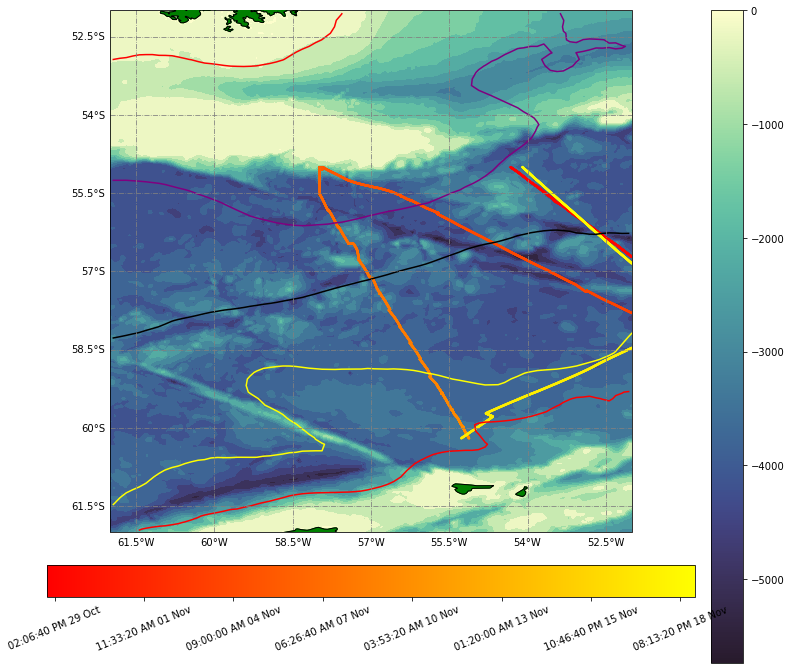

In [14]:
plot_region(etopo1, df_front_sel, df)


C:\Users\gian_\miniconda3\envs\mthesis\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\gian_\miniconda3\envs\mthesis\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


KeyError: 'lon'

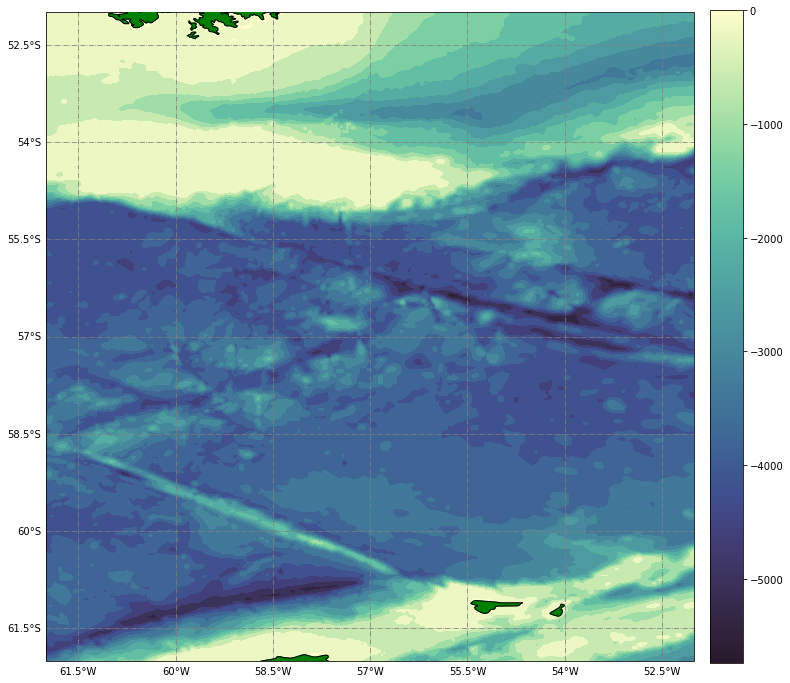

In [51]:
df_sel_1 = df.loc['2016-11-06 18':'2016-11-11 12']
plot_region(etopo1, df_front_sel, df_sel_1)
plt.savefig('results/analysis/25-02-22/JR16002a.png', format='png')

## functions

In [16]:
def QC_count(dataframe):
    position_QC = dataframe['POSITION_SEADATANET_QC'].value_counts()
    depth_QC = dataframe['DEPTH_SEADATANET_QC'].value_counts()
    time_QC = dataframe['TIME_SEADATANET_QC'].value_counts()
    conduc_QC = dataframe['CNDCSG01_SEADATANET_QC'].value_counts()
    PS_uncal_QC = dataframe['PSALSG01_SEADATANET_QC'].value_counts()
    PS_cal_QC = dataframe['PSALSU01_SEADATANET_QC'].value_counts()
    T_hull_QC = dataframe['TEMPHU01_SEADATANET_QC'].value_counts()
    T_tsg_QC = dataframe['TMESSG01_SEADATANET_QC'].value_counts()

    QC =[position_QC, depth_QC, time_QC, conduc_QC, PS_uncal_QC, PS_cal_QC, T_hull_QC, T_tsg_QC]

    df_QC = pd.DataFrame(QC)

    return df_QC

def drop_QC_var(dataframe):
    df = dataframe.drop(['SDN_CRUISE', 'crs', 'SDN_EDMO_CODE', 'SDN_STATION', 'SDN_LOCAL_CDI_ID',
       'SDN_BOT_DEPTH', 'POSITION_SEADATANET_QC', 'depth',
       'DEPTH_SEADATANET_QC', 'TIME_SEADATANET_QC', 'ATTNDR01_SEADATANET_QC', 'ATTNDR01', 'CPHLUMTF_SEADATANET_QC',
       'CPHLUMTF', 'POPTDR01_SEADATANET_QC', 'POPTDR01', 'PSALSG01_SEADATANET_QC',
       'PSALSU01_SEADATANET_QC','TMESSG01_SEADATANET_QC'], axis=1)
    return df

def nan_count(dataframe):
    aux = {}
    for var in dataframe.columns:
        index = var
        value = dataframe[var].isna().sum()
        aux[index] = [value]
    return pd.DataFrame(aux, index=['Nan_count']).transpose()

def time_difference(time_array):
    time_dif = []
    for i in range(len(time_array)-1):
        time_dif.append(time_array[i+1] - time_array[i])
    time_dif = np.array(time_dif).astype('timedelta64[s]').astype('float')
    return time_dif

def histograms(vel, distance):
    #Let's plot the distances and vessel speed in a histogram, with a cut-off line at 4ms-1

    fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(16,8))

    ax0.hist(vel, color='grey', alpha = 0.5, bins=30)

    ax0.axvline(x=np.median(vel), label=str(('Median = ') + str(round(np.median(vel),2)) 
        + str(' m')), color='black', linestyle='-.')
    ax0.axvline(x=np.mean(vel), label=str(('Mean = ') + str(round(np.mean(vel),2)) 
        + str(' m')), color='black', linestyle='--')
    ax0.axvline(x=np.quantile(vel, .10), label=str(('Quantile 10 = ') + str(round(np.quantile(vel, .10),2)) 
        + str(' m')), color='black', linestyle=':',)
    ax0.axvline(x=np.quantile(vel, .90), label=str(('Quantile 90 = ') + str(round(np.quantile(vel, .90),2)) 
        + str(' m')), color='black', linestyle=':')
    ax0.legend(loc='upper right')

    ax1.hist(distance, color='grey', alpha =0.5, bins=30)

    ax1.axvline(x=np.median(distance), label=str(('Median = ') + str(round(np.median(distance),2)) 
        + str(' m')), color='black', linestyle='-.')
    ax1.axvline(x=np.mean(distance), label=str(('Mean = ') + str(round(np.mean(distance),2)) 
        + str(' m')), color='black', linestyle='--')
    ax1.axvline(x=np.quantile(distance, .10), label=str(('Quantile 10 = ') + str(round(np.quantile(distance, .10),2)) 
        + str(' m')), color='black', linestyle=':',)
    ax1.axvline(x=np.quantile(distance, .90), label=str(('Quantile 90 = ') + str(round(np.quantile(distance, .90),2)) 
        + str(' m')), color='black', linestyle=':')
    ax1.legend(loc='upper right')

    ax0.axvline(x=2, label='speed cut off = 2ms-1 (120 m)', color='red', linestyle='-')
    ax0.axvline(x=10, label='speed cut off = 10ms-1 (600 m)', color='red', linestyle='-')

    ax1.axvline(x=120, label='speed cut off = 2ms-1 (120 m)', color='red', linestyle='-')
    ax1.axvline(x=600, label='speed cut off = 10ms-1 (600 m)', color='red', linestyle='-')

    #ax1.set_xticks(np.arange(0, 460, 60))

    ax0.set(xlabel='Vessel speed (ms-1)')
    ax1.set(xlabel='Distance (m)')

    ax0.legend(loc='upper center')
    
def stats(**kwargs):
    for i in kwargs:
        print('Min(' + str(i) + '): ' + str(np.min(np.array(kwargs[i]))))
        print('Max(' + str(i) + '): ' + str(np.max(np.array(kwargs[i]))))
        print('Mean(' + str(i) + '): ' + str(np.mean(np.array(kwargs[i]))))
        print('Median(' + str(i) + '): ' + str(np.median(np.array(kwargs[i]))))
        print( )

## df_sel_1

Method: I apply the count_flags function to the QC variables. If they are fine (only good values and interpolated values) drop
it from the dataset (the QC variable).

In [17]:
df_sel_1 = df.loc['2016-11-06 18':'2016-11-11 12']

In [18]:
QC_count(df_sel_1)

,49.0
POSITION_SEADATANET_QC,4740
DEPTH_SEADATANET_QC,4740
TIME_SEADATANET_QC,4740
CNDCSG01_SEADATANET_QC,4740
PSALSG01_SEADATANET_QC,4740
PSALSU01_SEADATANET_QC,4740
TEMPHU01_SEADATANET_QC,4740
TMESSG01_SEADATANET_QC,4740


In [19]:
df_sel_1 = drop_QC_var(df_sel_1)

In [20]:
nan_count(df_sel_1)

,Nan_count
lat,0
lon,0
CNDCSG01_SEADATANET_QC,0
CNDCSG01,0
PSALSG01,0
PSALSU01,0
TEMPHU01_SEADATANET_QC,0
TEMPHU01,0
TMESSG01,0


In [21]:
#Let's calculate the distances
distance_sel_1 = gsw.distance(df_sel_1['lon'], df_sel_1['lat'])

#And the cumulative distance
distance_cum = np.insert(np.cumsum(distance_sel_1), 0, 0)

df_sel_1['distance_cum'] = distance_cum

C:\Users\gian_\miniconda3\envs\mthesis\lib\site-packages\gsw\geostrophy.py:187: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lon = lon[np.newaxis, :]
C:\Users\gian_\miniconda3\envs\mthesis\lib\site-packages\gsw\geostrophy.py:188: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lat = lat[np.newaxis, :]


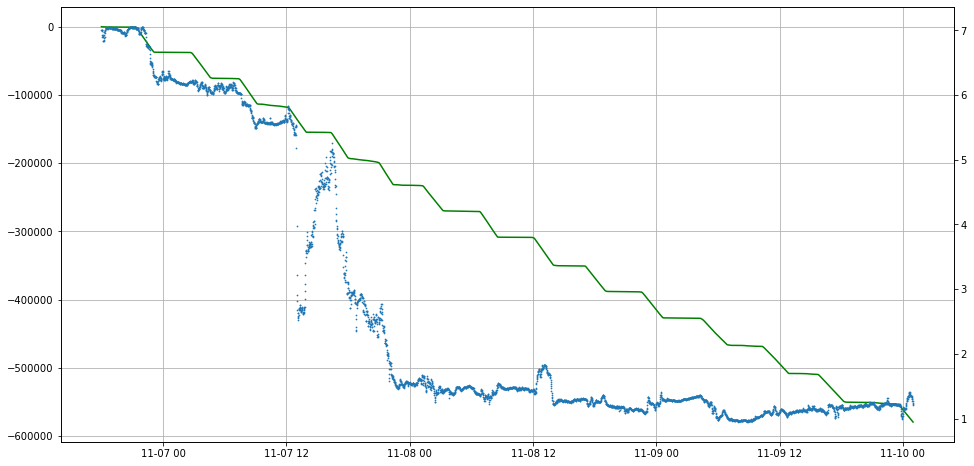

In [22]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(df_sel_1.index, -df_sel_1['distance_cum'], c='green')
ax1 = ax.twinx()
ax1.scatter(df_sel_1.index, df_sel_1['TMESSG01'], s=0.5)
ax.grid(axis='both', which='both')

In [23]:
time_dif_sel_1 = time_difference(df_sel_1.index)

In [24]:
vel_sel_1 = distance_sel_1/time_dif_sel_1

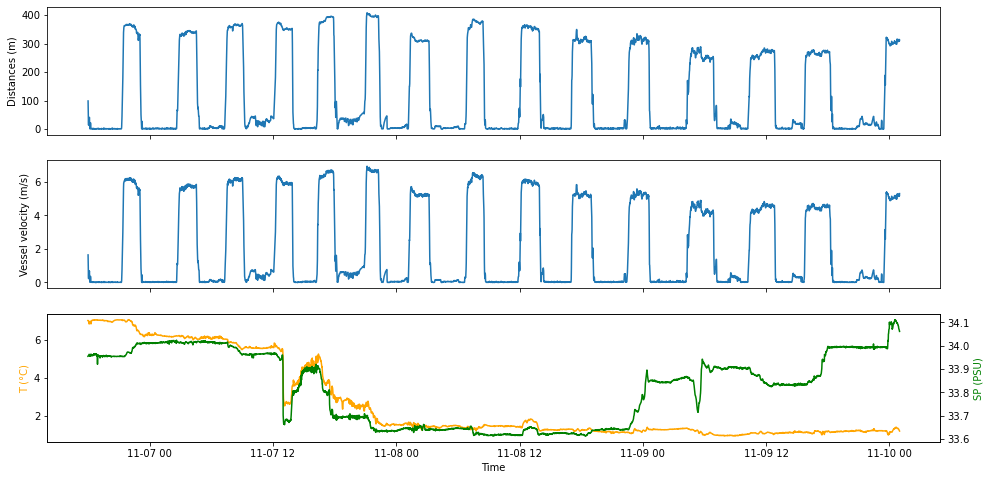

In [25]:
fig, (ax0,ax1,ax2) = plt.subplots(nrows=3, figsize=(16,8), sharex=True)
ax0.plot(df_sel_1.index[1:], distance_sel_1)
ax0.set(ylabel='Distances (m)')

ax1.plot(df_sel_1.index[1:], vel_sel_1)
ax1.set(ylabel='Vessel velocity (m/s)')

ax2.plot(df_sel_1.index, df_sel_1['TMESSG01'], color='orange')
ax2.set(xlabel='Time', ylabel='T (°C)')
ax2.yaxis.label.set_color('orange')
ax3 = ax2.twinx()
ax3.plot(df_sel_1.index, df_sel_1['PSALSU01'], color='green')
ax3.set(ylabel='SP (PSU)')
ax3.yaxis.label.set_color('green')



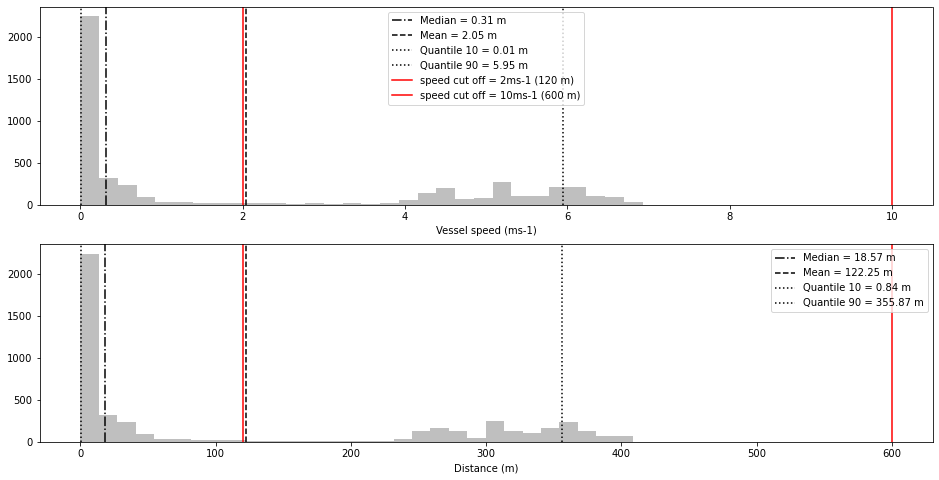

In [26]:
histograms(vel_sel_1, distance_sel_1)

In [27]:
stats(time=time_dif_sel_1, distance=distance_sel_1)

Min(time): 59.0
Max(time): 60.0
Mean(time): 59.74192867693606
Median(time): 60.0

Min(distance): 0.0
Max(distance): 408.69707750713064
Mean(distance): 122.25338843573685
Median(distance): 18.565592728062796



In [28]:
df_1 = df_sel_1
df_1['distance_aux'] = np.insert(distance_sel_1, 0, -999)
df_1['vel'] = np.insert(vel_sel_1, 0, 5.5)
df_1 = df_1.where(df_1['distance_aux'] > 120)
#df_sel_1 = df_sel_1[df_sel_1['vel'] > 2]
df_1 = df_1.drop('distance_aux', axis=1)

# distance_1 = gsw.distance(df_1['lon'], df_1['lat'])
# distance_cum = np.insert(np.cumsum(distance_1), 0, 0)
# df_1['distance_cum'] = distance_cum

In [29]:
distance_1_aux = gsw.distance(df_1['lon'].dropna(), df_1['lat'].dropna())
# distance_1_aux = distance_1_aux[~np.isnan(distance_1_aux)]

C:\Users\gian_\miniconda3\envs\mthesis\lib\site-packages\gsw\geostrophy.py:187: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lon = lon[np.newaxis, :]
C:\Users\gian_\miniconda3\envs\mthesis\lib\site-packages\gsw\geostrophy.py:188: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lat = lat[np.newaxis, :]


In [30]:
time_dif_1_aux = time_difference(df_1.dropna(axis=0).index)

In [31]:
#vel_1 = distance_1/time_dif_1

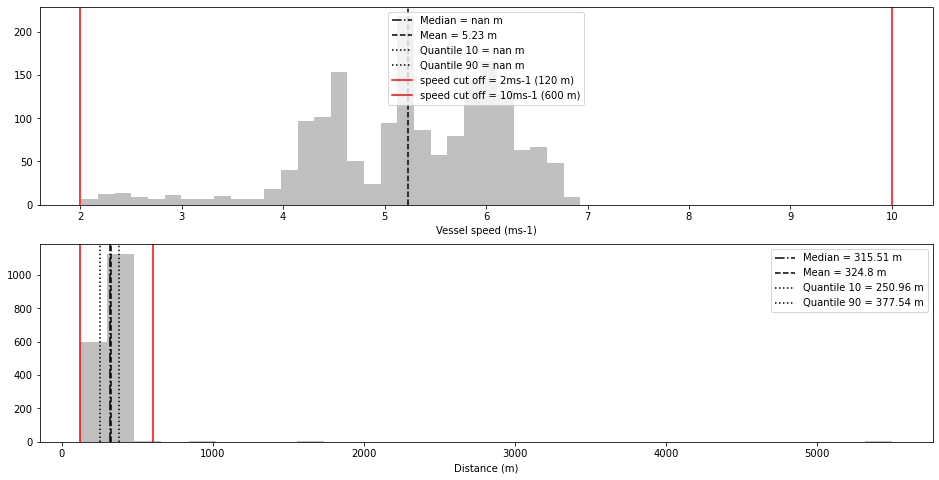

In [32]:
histograms(df_1['vel'], distance_1_aux)

In [33]:
stats(time=time_dif_1_aux/60, distance=distance_1_aux, velocity=df_1['vel'].dropna())

Min(time): 0.9833333333333333
Max(time): 316.98333333333335
Mean(time): 2.596655198776758
Median(time): 1.0

Min(distance): 121.55524988243921
Max(distance): 5494.204429991822
Mean(distance): 324.7984892320711
Median(distance): 315.5147730694382

Min(velocity): 2.0114814955579754
Max(velocity): 6.92706911029035
Mean(velocity): 5.2345579254588435
Median(velocity): 5.2696911929261265



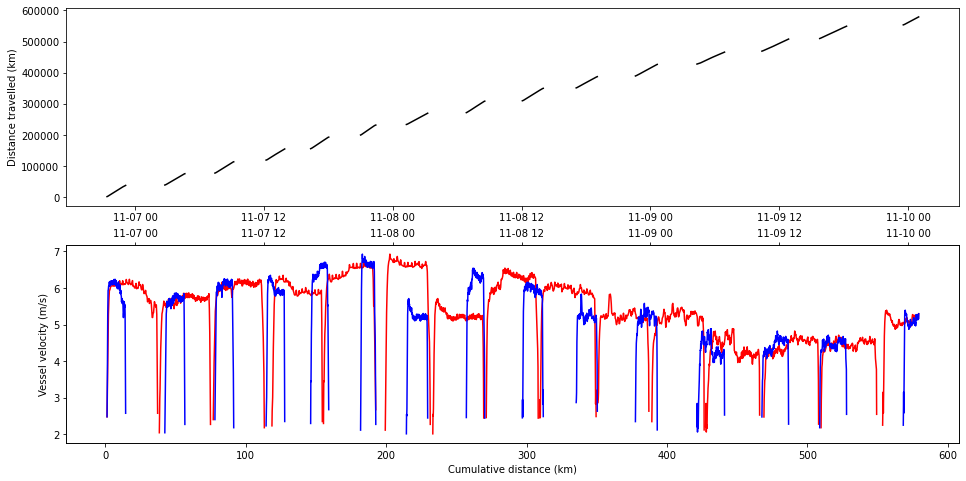

In [34]:
#Let's plot what we have got so far

fig, (ax0,ax1) = plt.subplots(nrows=2, figsize=(16,8))#, sharex=True)
ax0.plot(df_1.index, df_1['distance_cum'], color='black')
ax0.set(ylabel='Distance travelled (km)')

ax1.plot(df_1['distance_cum']/1000, df_1['vel'], color='red')
ax1.set(xlabel='Cumulative distance (km)', ylabel='Vessel velocity (m/s)')
ax2 = ax1.twiny()
ax2.plot(df_1.index, df_1['vel'], color='blue')


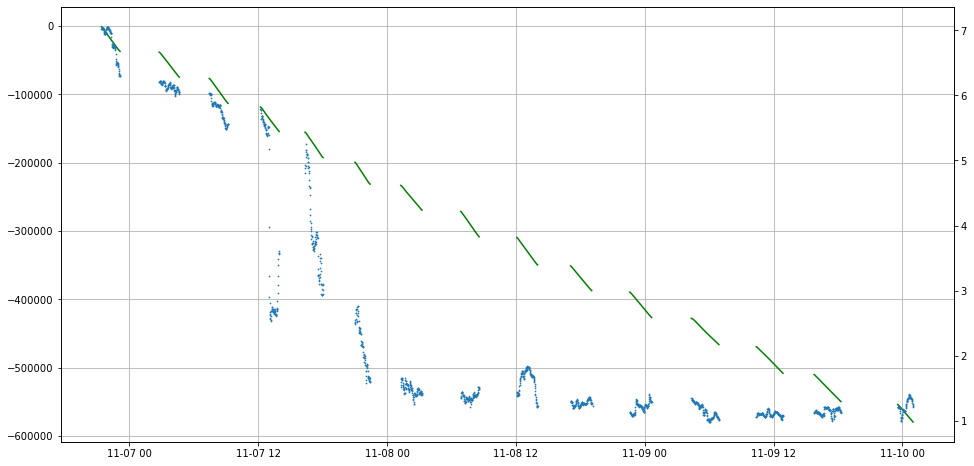

In [35]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(df_1.index, -df_1['distance_cum'], c='green')
ax1 = ax.twinx()
ax1.scatter(df_1.index, df_1['TMESSG01'], s=0.5)
ax.grid(axis='both', which='both')

## Density calculation

### df_1

In [36]:
ds

<xarray.Dataset>
Dimensions:                 (time: 32454)
Coordinates:
    lat                     (time) float64 -51.9 -51.9 -51.9 ... -52.12 -52.12
    lon                     (time) float64 -58.45 -58.45 ... -57.18 -57.18
    depth                   (time) float32 6.5 6.5 6.5 6.5 ... 6.5 6.5 6.5 6.5
  * time                    (time) datetime64[ns] 2016-10-28T11:06:59.998752 ...
Data variables: (12/25)
    SDN_CRUISE              |S80 b'JR16002'
    crs                     int32 0
    SDN_EDMO_CODE           int32 43
    SDN_STATION             |S80 b'JR16002_PRODQXF_SURF'
    SDN_LOCAL_CDI_ID        |S80 b'1836415'
    SDN_BOT_DEPTH           (time) float32 nan nan nan nan ... nan nan nan nan
    ...                      ...
    PSALSU01_SEADATANET_QC  (time) float32 nan nan nan nan ... 49.0 49.0 49.0
    PSALSU01                (time) float32 nan nan nan nan ... 33.85 33.85 33.85
    TEMPHU01_SEADATANET_QC  (time) float32 nan nan nan nan ... 49.0 49.0 49.0
    TEMPHU01                (time) float32 nan nan nan nan ... 7.163 7.174 7.187
    TMESSG01_SEADATANET_QC  (time) float32 nan nan nan nan ... 49.0 49.0 49.0
    TMESSG01                (time) float32 nan nan nan nan ... 7.629 7.635 7.643
Attributes:
    date_update:  2020-07-31T01:02:11+0100
    comment:      
    Conventions:  SeaDataNet_1.0 CF-1.6
    featureType:  trajectory
    title:        SeaDataNet NETCDF TRAJECTORY Climate Forecast 1.6 - GENERAT...

In [37]:
df_1['SA'] = gsw.SA_from_SP(df_1['PSALSG01'].values, 0, df_1['lon'].values, df_1['lat'].values)
df_1['CT'] = gsw.CT_from_t(df_1['SA'].values, df_1['TMESSG01'].values, 0)
df_1['rho'] = gsw.rho(df_1['SA'].values, df_1['CT'].values, 0)

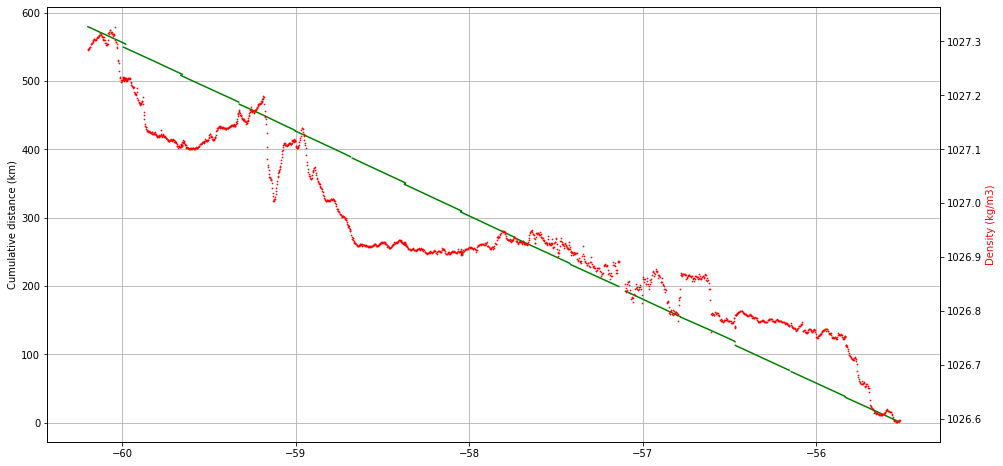

In [38]:
fig, ax = plt.subplots(figsize=(16,8))
df_plot = df_1
ax.plot(df_plot['lat'], df_plot['distance_cum']/1000, c='green')
ax.set_ylabel('Cumulative distance (km)')
ax1 = ax.twinx()
ax1.scatter(df_plot['lat'], df_plot['rho'], s=0.5, c='red')
ax1.set(xlabel='Time', ylabel='Density (kg/m3)')
ax.grid(axis='both', which='both')
ax1.yaxis.label.set_color('red')

## Lateral density scale histogram

In [39]:
def downsample(df, gridsize):
    from scipy.interpolate import griddata
    #create the distance grid
    distance_grid = np.arange(0, float(np.max(df.distance_cum)), gridsize)
    
    #we need to create a mask so the nans stay nans after gridding and are not interpolated
    df_mask = df.notna()[['rho', 'distance_cum']]
    df_mask['distance_cum'] = df['distance_cum']
    grid_mask = griddata(df_mask['distance_cum'].values, df_mask['rho'].values, distance_grid, method='linear')

    rho = griddata(df['distance_cum'].values, df['rho'].values, distance_grid, method='linear')*grid_mask
    lat = griddata(df['distance_cum'].values, df['lat'].values, distance_grid, method='linear')
    df_aux = pd.DataFrame(rho, columns=['rho'], index=distance_grid)
    df_aux['lat'] = lat
    return df_aux

def method_1(df):
    g=9.8
    rho_0 = 1025
    df_500 = downsample(df,500)
    df_500['bx_500'] = (-g/rho_0)*df_500['rho'].diff()/1000
    df_500['bx_1000'] = (-g/rho_0)*df_500['bx_500'].rolling(window=2).mean()
    df_500['bx_2000'] = (-g/rho_0)*df_500['bx_500'].rolling(window=4).mean()
    df_500['bx_5000'] = (-g/rho_0)*df_500['bx_500'].rolling(window=10).mean()
    df_500['bx_10000'] = (-g/rho_0)*df_500['bx_500'].rolling(window=20).mean()
    return df_500

def method_3(df):
    g=9.8
    rho_0 = 1025
    df_500 =  downsample(df, 500)
    df_500['rho_1000'] = df_500['rho'].rolling(2).mean()
    df_500['rho_2000'] = df_500['rho'].rolling(4).mean()
    df_500['rho_5000'] = df_500['rho'].rolling(10).mean()
    df_500['rho_10000'] = df_500['rho'].rolling(20).mean()
    df_500['bx_500'] = (-g/rho_0)*df_500['rho'].diff()/1000
    df_500['bx_1000'] = (-g/rho_0)*df_500['rho_1000'].diff()/1000
    df_500['bx_2000'] = (-g/rho_0)*df_500['rho_2000'].diff()/1000
    df_500['bx_5000'] = (-g/rho_0)*df_500['rho_5000'].diff()/1000
    df_500['bx_10000'] = (-g/rho_0)*df_500['rho_10000'].diff()/1000
    return df_500

### df_1

In [40]:
# import statsmodels.api as sm
# from statsmodels.regression.rolling import RollingOLS

In [41]:
distance_cum_1 = np.insert(np.cumsum(distance_sel_1), 0, 0)
df_1['time'] = df_1.index
df_1['distance_cum'] = distance_cum_1
df_1 = df_1.set_index(df_1['distance_cum'])
df_1

,lat,lon,CNDCSG01_SEADATANET_QC,CNDCSG01,PSALSG01,PSALSU01,TEMPHU01_SEADATANET_QC,TEMPHU01,TMESSG01,distance_cum,vel,SA,CT,rho,time
distance_cum,,,,,,,,,,,,,,,
0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,2016-11-06 18:00:00.000000
98.638053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.638053,NaN,NaN,NaN,NaN,2016-11-06 18:01:00.000800
155.055370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,155.055370,NaN,NaN,NaN,NaN,2016-11-06 18:02:00.001600
181.364085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,181.364085,NaN,NaN,NaN,NaN,2016-11-06 18:03:00.002400
194.956789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,194.956789,NaN,NaN,NaN,NaN,2016-11-06 18:03:59.998048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578110.985191,-60.188152,-55.126926,49.0,2.941665,34.077850,34.073849,49.0,0.34000,1.27305,578110.985191,5.244786,34.241868,1.277024,1027.289330,2016-11-10 00:54:59.999968
578426.063535,-60.190853,-55.125202,49.0,2.940835,34.074551,34.070549,49.0,0.32510,1.26455,578426.063535,5.251306,34.238554,1.268544,1027.287263,2016-11-10 00:56:00.000128
578737.268837,-60.193523,-55.123516,49.0,2.938970,34.072151,34.068150,49.0,0.30250,1.24635,578737.268837,5.274666,34.236145,1.250358,1027.286580,2016-11-10 00:56:59.999968


#### method 3

In [42]:
df_1_500 = method_3(df_1)

In [43]:
df_1_500

,rho,lat,rho_1000,rho_2000,rho_5000,rho_10000,bx_500,bx_1000,bx_2000,bx_5000,bx_10000
0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1500.0,1026.597060,-55.524634,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000.0,1026.596614,-55.528863,1026.596837,NaN,NaN,NaN,4.260027e-09,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
577000.0,1027.296308,-60.178611,1027.296758,1027.298994,1027.302749,1027.304966,8.606577e-09,1.542011e-08,1.861522e-08,1.221952e-08,-1.290462e-09
577500.0,1027.294285,-60.182914,1027.295297,1027.296834,1027.301388,1027.304857,1.933478e-08,1.397068e-08,2.065854e-08,1.301968e-08,1.040074e-09
578000.0,1027.289138,-60.187201,1027.291712,1027.294235,1027.299517,1027.304185,4.921132e-08,3.427305e-08,2.484658e-08,1.788550e-08,6.424114e-09
578500.0,1027.287101,-60.191488,1027.288120,1027.291708,1027.297689,1027.303271,1.947961e-08,3.434547e-08,2.415807e-08,1.747441e-08,8.739502e-09


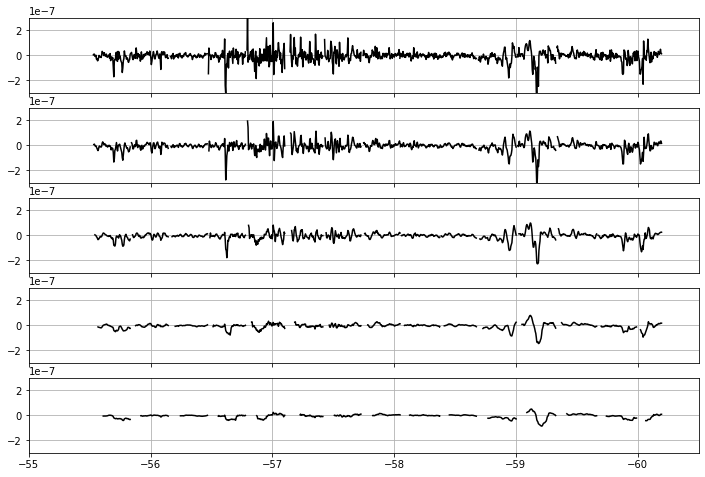

In [44]:
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=5, sharex=True, figsize=(12,8))
df = df_1_500
a = df['bx_500']
b = df['bx_1000']
c = df['bx_2000']
d = df['bx_5000']
e = df['bx_10000']
vars = [a, b, c, d, e,]
axes = [ax0, ax1, ax2, ax3, ax4]
for i in range(len(vars)):
    axes[i].plot(df['lat'], vars[i], color='black')
    axes[i].set_ylim((-3E-7,3E-7))
    axes[i].set_xlim((-55,-60.5))
    axes[i].grid()

C:\Users\gian_\miniconda3\envs\mthesis\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gian_\miniconda3\envs\mthesis\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gian_\miniconda3\envs\mthesis\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gian_\miniconda3\envs\mthesis\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\gian_\miniconda3\envs\mthesis\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


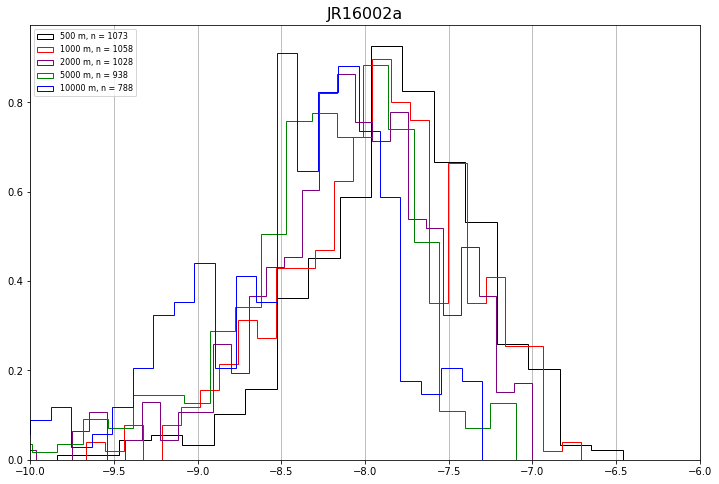

In [50]:
fig, ax = plt.subplots(figsize=(12,8))
df = df_1_500
a = df['bx_500'].dropna()
b = df['bx_1000'].dropna()
c = df['bx_2000'].dropna()
d = df['bx_5000'].dropna()
e = df['bx_10000'].dropna()
aux = [a, b, c, d, e]
label = ['500 m, n = ' + str(len(a)), '1000 m, n = ' + str(len(b)), '2000 m, n = ' + str(len(c)), '5000 m, n = ' + str(len(d)), '10000 m, n = ' + str(len(e))]
colors = ['black', 'red', 'purple', 'green', 'blue', 'orange']
for i in range(len(aux)):
    ax.hist(np.log10(aux[i]), histtype='step', density=True, bins=30, label=label[i], color=colors[i])
ax.legend(loc='upper left', fontsize=8)
ax.set_xlim(-10,-6)
ax.grid(axis='x')
# ax.set_xticks([-8,-7,-6,-5,-4])
ax.set_title('JR16002a', fontsize=16)
plt.savefig('results/analysis/25-02-22/hist_JR16002a.png', format='png')

In [46]:
from scipy.stats import kstest
df = df_1_500
a = df['bx_500'].dropna()
b = df['bx_1000'].dropna()
c = df['bx_2000'].dropna()
d = df['bx_5000'].dropna()
e = df['bx_10000'].dropna()
vars_name = ['a', 'b', 'c', 'd', 'e']
vars = [a, b, c, d, e]
for i in range(len(vars)):
    print('e and ' + vars_name[i] + ': ' + str(kstest(e, vars[i])))

e and a: KstestResult(statistic=0.21998547646193367, pvalue=8.948977651635638e-20)
e and b: KstestResult(statistic=0.17411935171235834, pvalue=1.9380053117856733e-12)
e and c: KstestResult(statistic=0.14030002567698355, pvalue=3.986427665747527e-08)
e and d: KstestResult(statistic=0.07216455792105463, pvalue=0.02166853965414628)
e and e: KstestResult(statistic=0.0, pvalue=1.0)


In [47]:
df_1_500.to_csv('data/03_processed/cruises/JR16002a')